In [30]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM,Dropout,Activation,Bidirectional,Embedding,Dense,Flatten,GlobalMaxPooling1D,SpatialDropout1D
from tensorflow.keras.layers import Conv1D,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.feature_extraction.text import CountVectorizer
import os
from gensim.models import Word2Vec, KeyedVectors
import tensorflow_hub as hub
from tensorflow.keras.regularizers import l2

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')
tf.__version__

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'2.7.0'

In [32]:
movies=pd.read_csv('/content/gdrive/MyDrive/movies_data.csv',encoding= 'unicode_escape')
movies.head()

,S.No.,Movie Name,Director Name,Release Year,Genre,Summary
0,1,Dune,Denis Villeneuve,2021,Action,"Paul Atreides, a brilliant and gifted young ma..."
1,2,Eternals,Chloé Zhao,2021,Action,"The Eternals, a race of immortal beings with s..."
2,3,No Time To Die,Cary Joji Fukunaga,2021,Action,James Bond is enjoying a tranquil life in Jama...
3,4,Halloween Kills,David Gordon Green,2021,Horror,The nightmare isn't over as unstoppable killer...
4,5,The French Dispatch,Wes Anderson,2021,Comedy,A love letter to journalists set in an outpost...


In [33]:
MainGenres=['Drama','Comedy','Action','Horror']
movies=movies[movies['Genre'].isin(MainGenres)]
len(movies)

3584

In [34]:
movies=movies.reset_index()
movies.head(5)

,index,S.No.,Movie Name,Director Name,Release Year,Genre,Summary
0,0,1,Dune,Denis Villeneuve,2021,Action,"Paul Atreides, a brilliant and gifted young ma..."
1,1,2,Eternals,Chloé Zhao,2021,Action,"The Eternals, a race of immortal beings with s..."
2,2,3,No Time To Die,Cary Joji Fukunaga,2021,Action,James Bond is enjoying a tranquil life in Jama...
3,3,4,Halloween Kills,David Gordon Green,2021,Horror,The nightmare isn't over as unstoppable killer...
4,4,5,The French Dispatch,Wes Anderson,2021,Comedy,A love letter to journalists set in an outpost...


In [35]:
movies['GenreID']=movies['Genre'].apply(lambda x:MainGenres.index(x))
movies.head(10)

,index,S.No.,Movie Name,Director Name,Release Year,Genre,Summary,GenreID
0,0,1,Dune,Denis Villeneuve,2021,Action,"Paul Atreides, a brilliant and gifted young ma...",2
1,1,2,Eternals,Chloé Zhao,2021,Action,"The Eternals, a race of immortal beings with s...",2
2,2,3,No Time To Die,Cary Joji Fukunaga,2021,Action,James Bond is enjoying a tranquil life in Jama...,2
3,3,4,Halloween Kills,David Gordon Green,2021,Horror,The nightmare isn't over as unstoppable killer...,3
4,4,5,The French Dispatch,Wes Anderson,2021,Comedy,A love letter to journalists set in an outpost...,1
5,5,6,Last Night in Soho,Edgar Wright,2021,Horror,An aspiring fashion designer is mysteriously a...,3
6,6,7,The Last Duel,Ridley Scott,2021,Drama,Jean de Carrouges is a respected knight known ...,0
7,7,8,Night Teeth,Adam Randall,2021,Action,A college student moonlighting as a chauffeur ...,2
8,9,10,Venom: Let There Be Carnage,Marco Beltrami,2021,Action,Eddie Brock is still struggling to coexist wit...,2
9,10,11,Free Guy,Shawn Levy,2021,Action,When a bank teller discovers he's actually a b...,2


In [36]:
no_drama=movies['Genre'].str.contains('Drama').sum()
no_comedy=movies['Genre'].str.contains('Comedy').sum()
no_horror=movies['Genre'].str.contains('Horror').sum()
no_action=movies['Genre'].str.contains('Action').sum()
print("Number of Drama movies:",no_drama)
print("Number of Comedy movies:",no_comedy)
print("Number of Horror movies:",no_horror)
print("Number of Action movies:",no_action)

Number of Drama movies: 1317
Number of Comedy movies: 1090
Number of Horror movies: 383
Number of Action movies: 794


[Text(0.5, 0, 'Genre'), Text(0.5, 1.0, 'Genre Counnt')]

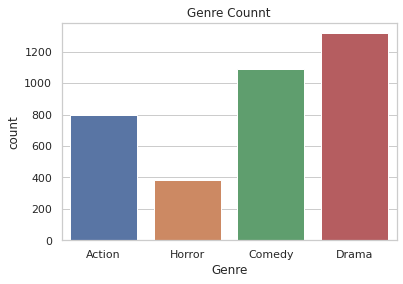

In [37]:
import seaborn as sns
sns.set(style='whitegrid')
figsize=(18, 6)
ax=sns.countplot(x=movies['Genre'], data=movies)
ax.set(xlabel='Genre',title="Genre Counnt")

In [38]:
import random
synNumber=random.randint(1,1000)
print(movies['Movie Name'].loc[synNumber])
print(movies['Genre'].loc[synNumber])
print(movies['Summary'].loc[synNumber])

Dil Bechara
Comedy
The emotional journey of two hopelessly in love youngsters, a young girl, Kizie, suffering from cancer, and a boy, Manny, whom she meets at a support group.


In [39]:
# nltk.download('stopwords')
# nltk.download('punkt')
# stop = stopwords.words('english')

In [40]:
data_clean=movies

In [41]:
# data_clean=pd.read_csv('/content/gdrive/MyDrive/clean_data.csv')

In [42]:
no_drama=data_clean['Genre'].str.contains('Drama').sum()
no_comedy=data_clean['Genre'].str.contains('Comedy').sum()
no_horror=data_clean['Genre'].str.contains('Horror').sum()
no_action=data_clean['Genre'].str.contains('Action').sum()
print("Number of Drama movies:",no_drama)
print("Number of Comedy movies:",no_comedy)
print("Number of Horror movies:",no_horror)
print("Number of Action movies:",no_action)

Number of Drama movies: 1317
Number of Comedy movies: 1090
Number of Horror movies: 383
Number of Action movies: 794


In [43]:
lemmatizer = WordNetLemmatizer()
i=0
def lemmatize_text(text):
    global i
    # print (type(text))
    # i=i+1
    # print(i)
    text=str(text)
    return " ".join([lemmatizer.lemmatize(w) for w in text.split()])

In [44]:
nltk.download('wordnet')
data_clean["Plot_clean"] = data_clean["Summary"].apply(lambda text: lemmatize_text(text))
data_clean.head()
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
data_clean['Plot_clean'] = data_clean['Plot_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
def  clean_text(df):
    df['Plot_clean'] = df['Plot_clean'].str.lower()
    df['Plot_clean'] = df['Plot_clean'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df['Plot_clean'] = df['Plot_clean'].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df
data_clean.head()

,index,S.No.,Movie Name,Director Name,Release Year,Genre,Summary,GenreID,Plot_clean
0,0,1,Dune,Denis Villeneuve,2021,Action,"Paul Atreides, a brilliant and gifted young ma...",2,"Paul Atreides, brilliant gifted young man born..."
1,1,2,Eternals,Chloé Zhao,2021,Action,"The Eternals, a race of immortal beings with s...",2,"The Eternals, race immortal superhuman power s..."
2,2,3,No Time To Die,Cary Joji Fukunaga,2021,Action,James Bond is enjoying a tranquil life in Jama...,2,James Bond enjoying tranquil life Jamaica leav...
3,3,4,Halloween Kills,David Gordon Green,2021,Horror,The nightmare isn't over as unstoppable killer...,3,The nightmare unstoppable killer Michael Myers...
4,4,5,The French Dispatch,Wes Anderson,2021,Comedy,A love letter to journalists set in an outpost...,1,A love letter journalist set outpost American ...


In [46]:
data_clean = clean_text(data_clean)
data_clean.head()

,index,S.No.,Movie Name,Director Name,Release Year,Genre,Summary,GenreID,Plot_clean
0,0,1,Dune,Denis Villeneuve,2021,Action,"Paul Atreides, a brilliant and gifted young ma...",2,paul atreides brilliant gifted young man born ...
1,1,2,Eternals,Chloé Zhao,2021,Action,"The Eternals, a race of immortal beings with s...",2,the eternals race immortal superhuman power se...
2,2,3,No Time To Die,Cary Joji Fukunaga,2021,Action,James Bond is enjoying a tranquil life in Jama...,2,james bond enjoying tranquil life jamaica leav...
3,3,4,Halloween Kills,David Gordon Green,2021,Horror,The nightmare isn't over as unstoppable killer...,3,the nightmare unstoppable killer michael myers...
4,4,5,The French Dispatch,Wes Anderson,2021,Comedy,A love letter to journalists set in an outpost...,1,a love letter journalist set outpost american ...


In [47]:
vect=CountVectorizer()
vect.fit(data_clean['Plot_clean'])

CountVectorizer()

In [48]:
len(vect.vocabulary_)

12492

In [49]:
vect.vocabulary_

{'paul': 8145,
 'atreides': 718,
 'brilliant': 1392,
 'gifted': 4482,
 'young': 12428,
 'man': 6722,
 'born': 1300,
 'great': 4639,
 'destiny': 2866,
 'beyond': 1100,
 'understanding': 11649,
 'must': 7358,
 'travel': 11435,
 'dangerous': 2620,
 'planet': 8357,
 'universe': 11707,
 'ensure': 3551,
 'future': 4354,
 'family': 3900,
 'people': 8199,
 'as': 632,
 'malevolent': 6708,
 'force': 4194,
 'explode': 3797,
 'conflict': 2216,
 'planets': 8358,
 'exclusive': 3727,
 'supply': 10826,
 'precious': 8534,
 'resource': 9273,
 'existence': 3756,
 'conquer': 2248,
 'fear': 3964,
 'survive': 10863,
 'the': 11150,
 'eternals': 3641,
 'race': 8849,
 'immortal': 5339,
 'superhuman': 10808,
 'power': 8508,
 'secretly': 9827,
 'lived': 6462,
 'earth': 3313,
 'thousand': 11213,
 'years': 12406,
 'reunite': 9324,
 'battle': 974,
 'evil': 3698,
 'deviants': 2906,
 'james': 5768,
 'bond': 1269,
 'enjoying': 3532,
 'tranquil': 11393,
 'life': 6392,
 'jamaica': 5765,
 'leaving': 6320,
 'active': 100,

In [50]:
X=vect.transform(data_clean['Plot_clean'])

In [51]:
print(X)

  (0, 632)	1
  (0, 718)	1
  (0, 1100)	1
  (0, 1300)	1
  (0, 1392)	1
  (0, 2216)	1
  (0, 2248)	1
  (0, 2620)	1
  (0, 2866)	1
  (0, 3551)	1
  (0, 3727)	1
  (0, 3756)	1
  (0, 3797)	1
  (0, 3900)	1
  (0, 3964)	1
  (0, 4194)	1
  (0, 4354)	1
  (0, 4482)	1
  (0, 4639)	1
  (0, 6708)	1
  (0, 6722)	1
  (0, 7358)	1
  (0, 8145)	1
  (0, 8199)	1
  (0, 8357)	1
  :	:
  (3581, 12428)	1
  (3582, 2989)	1
  (3582, 6259)	1
  (3582, 6392)	1
  (3582, 8210)	1
  (3582, 8663)	1
  (3582, 9949)	1
  (3582, 10560)	1
  (3582, 10958)	2
  (3582, 11152)	1
  (3582, 12428)	1
  (3583, 47)	1
  (3583, 1235)	1
  (3583, 1761)	1
  (3583, 1855)	1
  (3583, 3900)	1
  (3583, 4242)	1
  (3583, 5534)	1
  (3583, 5594)	1
  (3583, 6363)	1
  (3583, 6392)	1
  (3583, 6547)	1
  (3583, 7952)	1
  (3583, 10648)	1
  (3583, 11150)	1


In [52]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
vect.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'aaj',
 'aakash',
 'aaron',
 'abaddon',
 'abandon',
 'abandoned',
 'abandoning',
 'abby',
 'abbys',
 'abdali',
 'abduct',
 'abducted',
 'abducting',
 'abduction',
 'abductor',
 'abdullah',
 'abe',
 'abhay',
 'abhi',
 'abhijat',
 'abhiram',
 'abhishek',
 'abigail',
 'ability',
 'abla',
 'able',
 'aboard',
 'abode',
 'abortion',
 'about',
 'abraham',
 'abroad',
 'abruptly',
 'absconds',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorbed',
 'absurd',
 'absurdist',
 'abt',
 'abu',
 'abuse',
 'abused',
 'abuser',
 'abusive',
 'ac',
 'acacia',
 'academic',
 'academy',
 'acassuso',
 'accept',
 'acceptance',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accident',
 'accidental',
 'accidentally',
 'acclaimed',
 'accompanied',
 'accompanies',
 'accomplice',
 'accomplish',
 'accomplished',
 'according',
 'accosted',
 'account',
 'accountant',
 'accounts',
 'accumulate',
 'accumulates',
 'accurate',
 'accusations',
 'accuse',
 'accused',
 'accuses',
 'accustomed',
 'ace',


In [65]:
i=4500
j=90
words=vect.get_feature_names()[i:i+45]
pd.DataFrame(X[j:j+7,i:i+45].todense(),columns=words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,girardi,giri,girl,girlfriend,girlfriends,girls,girotto,giuliano,giulio,give,given,giving,gizem,glacial,glacier,gladiator,glamour,glass,glaswegian,glen,glenn,glickstein,glimpse,glittering,glittery,global,globe,gloomy,gloria,glorias,glorious,glory,gloves,gluttony,gnarly,gnaws,gnome,go,goa,goal,goals,god,goddess,godfather,godin
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data_clean['GenreID'], test_size=0.2, random_state=0)

**Random Forest**

In [67]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [71]:
print("training ",rf.score(X_train,y_train))
print("testing ",rf.score(X_test,y_test))

training  0.9968608301360307
testing  0.504881450488145


In [68]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[200  40  16   4]
 [132  77  12   1]
 [ 70  13  71   0]
 [ 46  12   9  14]]
              precision    recall  f1-score   support

           0       0.45      0.77      0.56       260
           1       0.54      0.35      0.42       222
           2       0.66      0.46      0.54       154
           3       0.74      0.17      0.28        81

    accuracy                           0.50       717
   macro avg       0.60      0.44      0.45       717
weighted avg       0.55      0.50      0.48       717

0.504881450488145


In [72]:
import joblib
joblib.dump(rf, "./random_forest.joblib")

['./random_forest.joblib']

<Figure size 432x288 with 0 Axes>

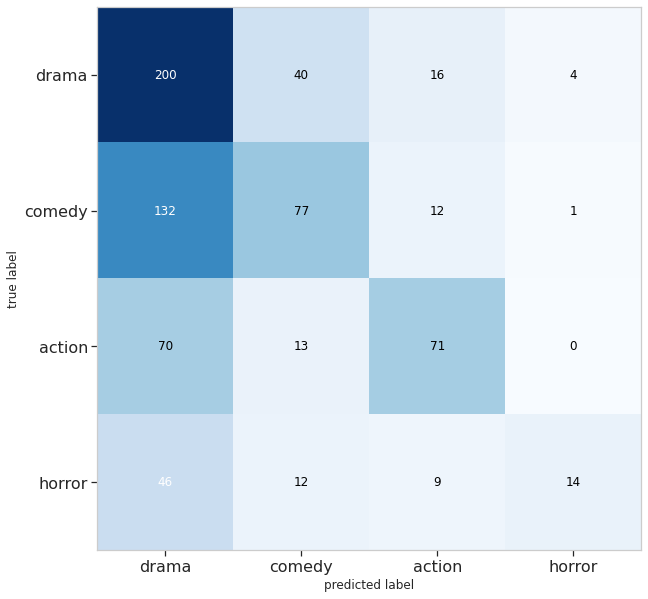

In [69]:
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(10,10), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(4), ['drama','comedy','action','horror'], fontsize=16)
plt.yticks(range(4), ['drama','comedy','action','horror'], fontsize=16)
plt.show()

In [80]:
print(X_train[0])

  (0, 2236)	1
  (0, 3637)	1
  (0, 3940)	1
  (0, 4502)	1
  (0, 5627)	1
  (0, 5739)	1
  (0, 7782)	1
  (0, 7792)	1
  (0, 8619)	1
  (0, 9149)	1
  (0, 9391)	1
  (0, 10696)	1
  (0, 11011)	1
  (0, 11536)	1
  (0, 12046)	1
  (0, 12400)	1


In [81]:
rf.predict(X_train[99])

array([2])

**LSTM**

In [ ]:
max_num_words=5000
max_seq_len=100
tokenizer = Tokenizer(num_words=max_num_words,filters='!"#$&%()*+-./:;<=>?@[\]^_`{|}~',lower=True)
tokenizer.fit_on_texts((data_clean['Plot_clean'].values))
sequences=tokenizer.texts_to_sequences((data_clean['Plot_clean'].values))
word_index=tokenizer.word_index
print("unique tokens:",len(word_index))
# max_len=np.max([len(sequence) for sequence in sequences])
print("Max length:",max_seq_len)
data = pad_sequences(sequences, maxlen=max_seq_len)
print("Shape of data tensor:",data.shape)

unique tokens: 12510
Max length: 100
Shape of data tensor: (3584, 100)


In [ ]:
data[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    3,
        318, 1404, 3673,  205, 1241,  843,  257, 1242,  134,  550,  184,
        198], dtype=int32)

In [ ]:
labels=np.asarray(data_clean['GenreID'].values)
labels=to_categorical(labels,num_classes=4)
print('Label:',labels.shape)
labels[50]

Label: (3584, 4)


array([0., 0., 0., 1.], dtype=float32)

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(data,labels,test_size=0.10,random_state=42,shuffle=True)

In [ ]:
embedding_dim=100
model=Sequential()
model.add(Embedding(input_dim=max_num_words,output_dim=embedding_dim,input_length=data.shape[1]))
model.add(SpatialDropout1D(0.3))
# model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(Dropout(0.3))
model.add(LSTM(64,return_sequences=True,activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
# model.add(LSTM(8))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(LSTM(64,return_sequences=True))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(LSTM(64,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(LSTM(32,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-4,decay=1e-6),metrics=['categorical_accuracy'])
model.summary()
# 32,kernel_regularizer=l2(0.001),input_shape=(X_train.shape[1:]),activation='tanh'

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 100, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           42240     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 batch_normalization_1 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (None, 32)               

In [ ]:
filepath="MovieGenrePredictionUsingPlotSummariesmodel1.h5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True)
callbacks_list = [checkpoint]
len(X_train),len(X_val)

(3225, 359)

In [ ]:
history=model.fit(X_train,y_train, epochs=30, callbacks=callbacks_list, batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
101/101 [==============================] - 13s 127ms/step - loss: 0.3141 - categorical_accuracy: 0.8940 - val_loss: 2.0778 - val_categorical_accuracy: 0.4568
Epoch 2/30
101/101 [==============================] - 13s 124ms/step - loss: 0.3111 - categorical_accuracy: 0.8924 - val_loss: 2.1423 - val_categorical_accuracy: 0.4318
Epoch 3/30
101/101 [==============================] - 13s 124ms/step - loss: 0.2737 - categorical_accuracy: 0.9026 - val_loss: 2.1729 - val_categorical_accuracy: 0.4680
Epoch 4/30
101/101 [==============================] - 13s 126ms/step - loss: 0.2476 - categorical_accuracy: 0.9157 - val_loss: 2.2445 - val_categorical_accuracy: 0.4596
Epoch 5/30
101/101 [==============================] - 13s 127ms/step - loss: 0.2681 - categorical_accuracy: 0.9141 - val_loss: 2.2871 - val_categorical_accuracy: 0.4624
Epoch 6/30
101/101 [==============================] - 12s 123ms/step - loss: 0.2534 - categorical_accuracy: 0.9132 - val_loss: 2.3955 - val_categorical_acc

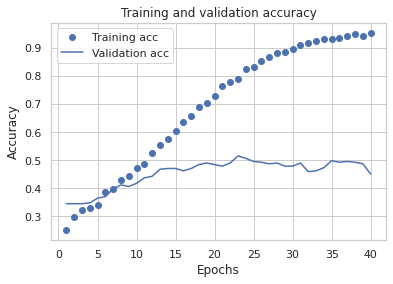

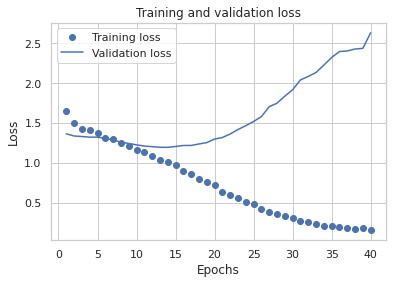

In [ ]:

acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.python.keras.models import load_model

best_model = load_model('MovieGenrePredictionUsingPlotSummariesmodel1.h5')

In [ ]:
batch_size=32
steps_test=int(len(X_val)/batch_size)
result = best_model.evaluate(X_val, y_val, steps=steps_test,verbose=1)
print("Validation-set accuracy: {0:.2%}".format(result[1]))

11/11 [==============================] - 1s 26ms/step - loss: 1.1960 - categorical_accuracy: 0.4708
Validation-set accuracy: 47.08%


In [ ]:
best_model.save('fypmodel{:.2%}.h5'.format(result[1]))

In [ ]:
preds = best_model.predict(X_val, batch_size=128,verbose=1)
preds=np.around(preds)

orig_val_labels=np.argmax(y_val,axis=1)
predicted_labels=np.argmax(preds,axis=1)

orig_val_labels=np.reshape(orig_val_labels,(len(X_val),1))
predicted_labels=np.reshape(predicted_labels,(len(X_val),1))

print(predicted_labels.shape)
print(orig_val_labels.shape)

3/3 [==============================] - 1s 71ms/step
(359, 1)
(359, 1)


<Figure size 432x288 with 0 Axes>

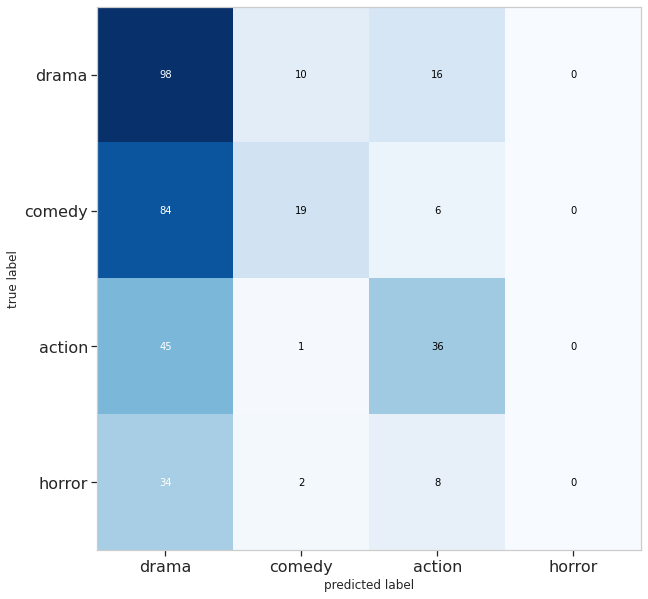

In [ ]:
%matplotlib inline
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_val_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm,figsize=(10,10), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(4), ['drama','comedy','action','horror'], fontsize=16)
plt.yticks(range(4), ['drama','comedy','action','horror'], fontsize=16)
plt.show()

In [ ]:
MainGenres=['drama','comedy','action','horror']
print(classification_report(orig_val_labels,predicted_labels,target_names=MainGenres))

              precision    recall  f1-score   support

       drama       0.38      0.79      0.51       124
      comedy       0.59      0.17      0.27       109
      action       0.55      0.44      0.49        82
      horror       0.00      0.00      0.00        44

    accuracy                           0.43       359
   macro avg       0.38      0.35      0.32       359
weighted avg       0.43      0.43      0.37       359



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
